In [88]:
import xymass
import numpy as np
import scipy
import astropy.units as u
%matplotlib inline
import matplotlib.pyplot as plt

In [89]:
n_object=100000 #sample size
f_binary=0.5 #binary fraction

In [90]:
#draw sample of psoitions from specified density profile.
#Since these are positions of center of masses in binary systems, 
#r_scale must be specified with units via astropy

r2d=xymass.sample_r2d(size=n_object,model='plum',r_scale=100.*u.pc,ellipticity=0.,position_angle=0.) 

In [91]:
#draw sample from specified mass function.
#Since these are masses of primaries in binary systems, must specify units via astropy

m_min=0.1
mass_primary=xymass.sample_imf(size=n_object,model='kroupa',m_min=m_min).mass*u.M_sun

In [92]:
#add binary companions according to specified binary fraction with Raghavan etal. 2010 parameters to sample 2body orbits

r2d_with_binaries_raghavan=xymass.add_binaries_physical(r2d.r_xyz,mass_primary,f_binary=f_binary,\
                                               m_min=m_min,binary_model='Raghavan2010')

In [93]:
#add binary companions according to specified binary fraction with Duquennoy & Mayor(1991) parameters to sample 2body orbits

r2d_with_binaries_dm91=xymass.add_binaries_physical(r2d.r_xyz,mass_primary,f_binary=f_binary,\
                                           m_min=m_min,binary_model='DM91')

In [94]:
#add binary companions according to mass ratio, period and eccentricity distributions sampled by the user to sample 2body orbits

#get array of m_secondary / m_primary, sampled from uniform distribution subject to constraint M_2 > 0.1 Msun

mass_ratio=np.random.uniform(size=n_object,low=m_min/mass_primary.value,high=1.) 

#alternatively, if secondary mass is independent of primary mass, sample secondary mass here.  
#Can pass either mass_ratio or mass_secondary to add_binaries function
mass_secondary=xymass.sample_imf(size=n_object,model='kroupa',m_min=m_min).mass*u.M_sun 

#get array of orbital period (years), sampled from truncated log-normal distribution

period=10.**xymass.sample_normal_truncated(size=n_object,loc=5.03,scale=2.28,\
                                           min_value=-np.inf,max_value=np.inf)/364.25*u.yr 

#get array of orbital eccentricity, sampled from truncated log-normal distribution

eccentricity=xymass.sample_normal_truncated(size=n_object,loc=0.31,scale=0.17,min_value=0.,max_value=1.)
    
r2d_with_binaries_user=xymass.add_binaries_physical(r2d.r_xyz,mass_primary,f_binary=f_binary,m_min=m_min,\
                                           mass_ratio=mass_ratio,period=period,eccentricity=eccentricity) 

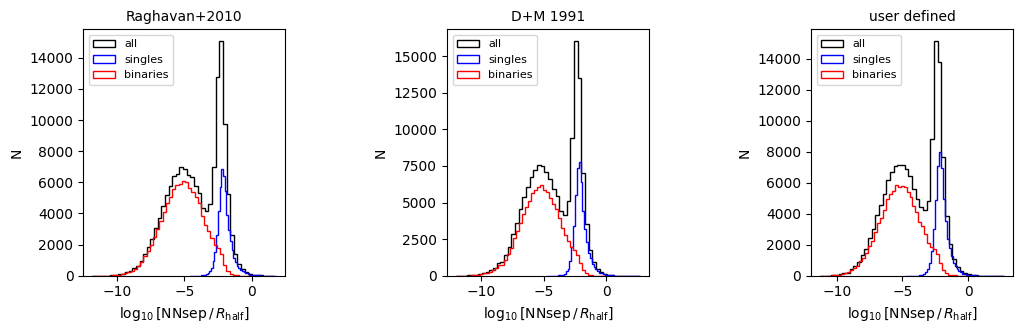

In [95]:
#plot nearest neighbor separation function for each case

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
#ax4=fig.add_subplot(224)
fig.subplots_adjust(wspace=0.8,hspace=0.5)

ax=[ax1,ax2,ax3]
title=['Raghavan+2010','D+M 1991','user defined']

i=0
for sample in [r2d_with_binaries_raghavan,r2d_with_binaries_dm91,r2d_with_binaries_user]:
    xy=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]]
    xy_singles=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]][sample.item==0]
    xy_binaries=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]][sample.item>0]
    
    tree=scipy.spatial.KDTree(xy.to(r2d.rhalf_2d.unit).value)
    tree_singles=scipy.spatial.KDTree(xy_singles.to(r2d.rhalf_2d.unit).value)
    tree_binaries=scipy.spatial.KDTree(xy_binaries.to(r2d.rhalf_2d.unit).value)
    nn=tree.query(xy.value,k=2)[0].T[1]#gives array of NN distance for each item in sample
    nn_singles=tree_singles.query(xy_singles.value,k=2)[0].T[1]
    nn_binaries=tree_binaries.query(xy_binaries.value,k=2)[0].T[1]
            
    ax[i].hist(np.log10(nn/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='k',label='all')
    ax[i].hist(np.log10(nn_singles/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='b',label='singles')
    ax[i].hist(np.log10(nn_binaries/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='r',label='binaries')
    ax[i].set_xlabel(r'$\log_{10}[\mathrm{NN sep}\,/\,R_{\rm half}]$',fontsize=10)
    ax[i].set_title(title[i],fontsize=10)
    ax[i].set_ylabel('N')
    ax[i].legend(loc=2,fontsize=8)

    i+=1
    
plt.show()


In [96]:
#Instead, add binary companions with separation functions specified by analytic model instead of orbit calculation

#specify lower and upper bounds of separation function

s_min=1.*u.AU #minimum separation
s_max=100000*u.AU #maximum separation

In [97]:
pl_alpha=1.001 #power law, index, defined so 2D separation function is dN/ds propto s^(-alpha)

#add binary companions according to 2D separation function that is power law
r2d_with_binaries_pl=xymass.add_binaries_func(r2d.r_xyz,\
                                              separation_func='pl',mass_primary=mass_primary,\
                                              mass_secondary=mass_secondary,f_binary=f_binary,s_min=s_min,\
                                              s_max=s_max,alpha=pl_alpha,projected=True) #project=True if separation function is 2D, False if 3D


In [98]:
bpl_s_break=100.*u.AU #broken power law, break separation
bpl_alpha1=1.01 #broken power law, index at s < s_break
bpl_alpha2=2. #broken power law, index at s > s_break

#add binary companions according to 2D separation function that is broken power law
r2d_with_binaries_bpl=xymass.add_binaries_func(r2d.r_xyz,\
                                               separation_func='bpl',mass_primary=mass_primary,\
                                               f_binary=f_binary,mass_ratio=mass_ratio,s_min=s_min,\
                                               s_max=s_max,s_break=bpl_s_break,alpha1=bpl_alpha1,\
                                               alpha2=bpl_alpha2,projected=True) #project=True if separation function is 2D, False if 3D


In [99]:
lognormal_loc=np.log10((100.*u.AU).to(s_min.unit)/s_min.unit) #lognormal, mean (linear) separation
lognormal_scale=np.log10((10.*u.AU).to(s_min.unit)/s_min.unit) #lognormal, standard deviation of (linear) separation

#add binary companions according to 3D separation function that is lognormal
r2d_with_binaries_lognormal=xymass.add_binaries_func(r2d.r_xyz,\
                                                     separation_func='lognormal',mass_primary=mass_primary,\
                                                     mass_secondary=mass_secondary,f_binary=f_binary,\
                                                     s_min=s_min,s_max=s_max,loc=lognormal_loc,\
                                                     scale=lognormal_scale,projected=False) #project=True if separation function is 2D, False if 3D


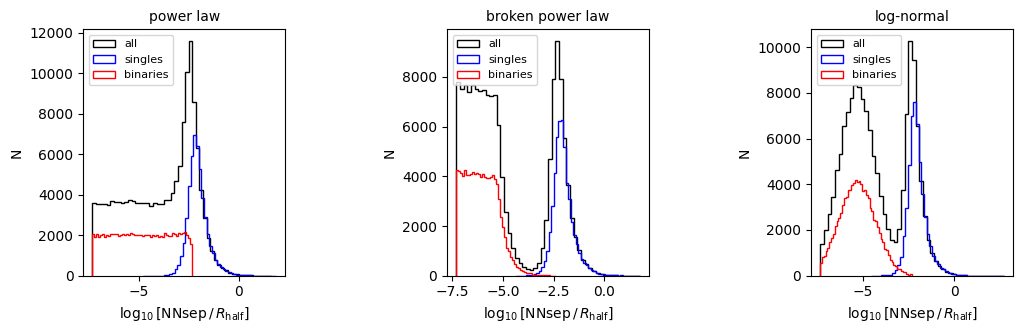

In [100]:
#plot nearest neighbor separation function for each case

fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
#ax4=fig.add_subplot(224)
fig.subplots_adjust(wspace=0.8,hspace=0.5)

ax=[ax1,ax2,ax3]
title=['power law','broken power law','log-normal']

i=0
for sample in [r2d_with_binaries_pl,r2d_with_binaries_bpl,r2d_with_binaries_lognormal]:
    xy=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]]
    xy_singles=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]][sample.item==0]
    xy_binaries=np.c_[sample.r_xyz.T[0],sample.r_xyz.T[1]][sample.item>0]
    
    tree=scipy.spatial.KDTree(xy.to(r2d.rhalf_2d.unit).value)
    tree_singles=scipy.spatial.KDTree(xy_singles.to(r2d.rhalf_2d.unit).value)
    tree_binaries=scipy.spatial.KDTree(xy_binaries.to(r2d.rhalf_2d.unit).value)
    nn=tree.query(xy.value,k=2)[0].T[1]#gives array of NN distance for each item in sample
    nn_singles=tree_singles.query(xy_singles.value,k=2)[0].T[1]
    nn_binaries=tree_binaries.query(xy_binaries.value,k=2)[0].T[1]
            
    ax[i].hist(np.log10(nn/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='k',label='all')
    ax[i].hist(np.log10(nn_singles/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='b',label='singles')
    ax[i].hist(np.log10(nn_binaries/r2d.rhalf_2d.value),bins=50,histtype='step',density=False,color='r',label='binaries')
    ax[i].set_xlabel(r'$\log_{10}[\mathrm{NN sep}\,/\,R_{\rm half}]$',fontsize=10)
    ax[i].set_title(title[i],fontsize=10)
    ax[i].set_ylabel('N')
    ax[i].legend(loc=2,fontsize=8)

    i+=1
    
   
plt.show()

In [49]:
vars(r2d_with_binaries_user)

{'r_xyz': <Quantity [[ 3.62243553e+01,  1.92684548e+01,  0.00000000e+00],
            [-1.96811716e+01, -3.00189882e+01,  0.00000000e+00],
            [-1.98827238e+01,  6.00954067e+01, -2.20983010e-03],
            ...,
            [-3.60678453e+01,  9.20814244e+00,  0.00000000e+00],
            [ 5.33642706e+01, -1.05699844e+02,  0.00000000e+00],
            [-9.10178005e+01, -2.95022109e+02,  0.00000000e+00]] pc>,
 'mass': array([0.13504987, 0.50268175, 0.13838103, ..., 0.26836959, 1.97040863,
        0.22914447]),
 'item': array([0, 0, 1, ..., 0, 0, 0]),
 'companion': array([-999, -999,    3, ..., -999, -999, -999]),
 'binary_model': 'user'}

In [71]:
r2d_with_binaries_pl.item

array([1, 2, 1, ..., 0, 0, 0])

In [18]:
r2d_with_binaries_pl.companion[3]

2

In [76]:
len(np.where(r2d_with_binaries_pl.item==2)[0])

49762

## r2d_with_binaries_user.companion

In [77]:
r2d_with_binaries_pl.r_xyz

<Quantity [[  36.14133738,   19.33370545,    0.        ],
           [  36.22729819,   19.26614177,    0.        ],
           [ -19.68043317,  -30.02488144,    0.        ],
           ...,
           [ -36.06784528,    9.20814244,    0.        ],
           [  53.36427057, -105.69984422,    0.        ],
           [ -91.01780046, -295.02210871,    0.        ]] pc>

In [83]:
np.c_[r2d_with_binaries_pl.r_xyz.T[0],r2d_with_binaries_pl.r_xyz.T[1]]

<Quantity [[  36.14133738,   19.33370545],
           [  36.22729819,   19.26614177],
           [ -19.68043317,  -30.02488144],
           ...,
           [ -36.06784528,    9.20814244],
           [  53.36427057, -105.69984422],
           [ -91.01780046, -295.02210871]] pc>